# <span style="color:#F72585"><center>Construcción automática de texto </center></span>

<center>Introducción</center>

<figure>
<center>
<img src="../Imagenes/text_generation_sampling.png" width="600" height="600" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Muestreo  de palabras</p>
</figcaption>
</figure>

Fuente: [TensorFlow](https://www.tensorflow.org/tutorials/text/text_generation)

##   <span style="color:#4361EE">Introducción</span>

Gran conjunto de datos basado en sonetos de Shakespeare.


##   <span style="color:blue">Librerías</span>


In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2022-07-27 23:14:06.193460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 23:14:06.193913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np 

from tensorflow.keras.utils import plot_model

## <span style="color:#4361EE">Lee los datos</span>

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2022-07-27 23:14:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.250.78.112, 142.250.78.144, 142.250.78.176, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.250.78.112]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 93578 (91K) [text/plain]
Guardando como: “/tmp/sonnets.txt”

/tmp/sonnets.txt    100%[===================>]  91,38K  --.-KB/s    en 0,06s   

2022-07-27 23:14:15 (1,49 MB/s) - “/tmp/sonnets.txt” guardado [93578/93578]



## <span style="color:#4361EE">Tokeniza el texto</span>


In [4]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

#print('Dictionary: ',tokenizer.word_index,'\n')
print('índice de "rage" = ',tokenizer.word_index['rage'])
print('\nNúmero total de palabras en el Tokenizador (+OOV) =',total_words,'\n')

# Muestra parte del corpus
print('Primeras líneas del corpus: \n')
corpus[0:10]

índice de "rage" =  443

Número total de palabras en el Tokenizador (+OOV) = 3211 

Primeras líneas del corpus: 



['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

## <span style="color:#4361EE">Crea n-Grams para datos de entrenamiento y etiquetas</span>

In [5]:
# crear secuencias de entrada usando una lista de tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
print('input_sequences[0:10] = ',input_sequences[:10],'\n')

# Determine el n-gram más largo
max_seq_test_len = max([len(x) for x in input_sequences])
print('\nlongitud del  n-grama más largo:',max_seq_test_len)


input_sequences[0:10] =  [[34, 417], [34, 417, 877], [34, 417, 877, 166], [34, 417, 877, 166, 213], [34, 417, 877, 166, 213, 517], [8, 878], [8, 878, 134], [8, 878, 134, 351], [8, 878, 134, 351, 102], [8, 878, 134, 351, 102, 156]] 


longitud del  n-grama más largo: 11


### <span style="color:#4CC9F0">¿Qué hizo tokenizer?</span>

In [6]:
line = corpus[0]
token_list = tokenizer.texts_to_sequences([line])
print(line)
print(token_list)
print(token_list[0])

from fairest creatures we desire increase,
[[34, 417, 877, 166, 213, 517]]
[34, 417, 877, 166, 213, 517]


### <span style="color:#4CC9F0">Agrega PAD para tener secuencias de la misma longitud</span>

In [7]:
# secuencias de pad
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# crea predictores y etiqueta
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

In [8]:
print(input_sequences.shape)
print(predictors.shape)
print(label.shape)

(15462, 11)
(15462, 10)
(15462,)


In [9]:
print(len(predictors))
print(len(label))

15462
15462


In [10]:
print(input_sequences[0:3]) # secuencia completa
print('\n')
print(predictors[0:3]) # secuencia hasta el anterior al último
print('\n')
print(label[0:3]) # el último de la secuencia

[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]]


[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]]


[417 877 166]


### <span style="color:#4CC9F0">Convierte etiquetas a one-hot</span>

In [11]:
label = to_categorical(label, num_classes=total_words)
print(label.shape)

(15462, 3211)


## <span style="color:#4361EE">Crea el modelo</span>

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-07-27 23:14:26.481017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 23:14:26.481074: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-27 23:14:26.481107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kamilo44): /proc/driver/nvidia/version does not exist
2022-07-27 23:14:26.481780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1605)              162105    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                        

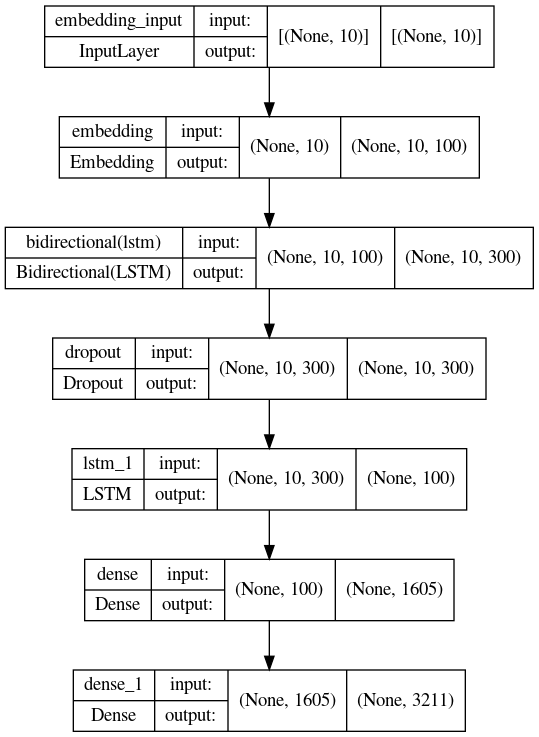

In [13]:
print(model.summary())
plot_model(model, to_file='../Imagenes/sonetos.png', 
           show_shapes=True)

## <span style="color:#4361EE">Entrena</span>

In [14]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 93s 164ms/step - loss: 6.9090 - accuracy: 0.0203
Epoch 2/100
484/484 [==============================] - 74s 153ms/step - loss: 6.4993 - accuracy: 0.0204
Epoch 3/100
484/484 [==============================] - 73s 151ms/step - loss: 6.4086 - accuracy: 0.0237
Epoch 4/100
484/484 [==============================] - 73s 150ms/step - loss: 6.2919 - accuracy: 0.0296
Epoch 5/100
484/484 [==============================] - 75s 154ms/step - loss: 6.1910 - accuracy: 0.0357
Epoch 6/100
484/484 [==============================] - 74s 154ms/step - loss: 6.1015 - accuracy: 0.0384
Epoch 7/100
484/484 [==============================] - 74s 153ms/step - loss: 6.0185 - accuracy: 0.0426
Epoch 8/100
484/484 [==============================] - 74s 152ms/step - loss: 5.9363 - accuracy: 0.0458
Epoch 9/100
484/484 [==============================] - 74s 152ms/step - loss: 5.8381 - accuracy: 0.0514
Epoch 10/100
484/484 [==============================] - 73s 152m

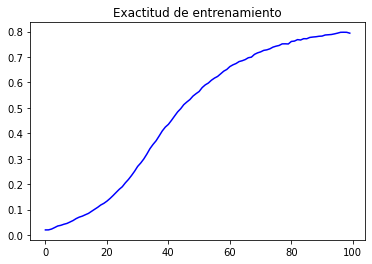

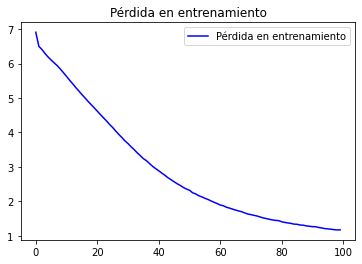

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Exactitud de entrenamiento')
plt.title('Exactitud de entrenamiento')

plt.figure()

plt.plot(epochs, loss, 'b', label='Pérdida en entrenamiento')
plt.title('Pérdida en entrenamiento')
plt.legend()

plt.show()

## <span style="color:#4361EE">Genera texto automáticamente</span>

In [19]:
seed_text = "Who are you, so too cruel?"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    output_word = ""
    
    print(predicted)
    
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[[6.5008687e-20 1.0673048e-02 7.4008440e-08 ... 1.6198371e-20
  2.9688252e-31 2.1124412e-34]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
#help(model)

¿Quién eres, tan cruel? en ti tienes libre, ten cuidado, muéstrame el cielo muerto, consideró que yacía en ella mucho tiempo solo, no debes esforzarte por escribir el tono más amplio, todavía verdadero, palabras de orgullo, he aquí, viejo odio, parte vieja, mi punto de vista, eres orgullo, demuéstrame 'no hay nada nuevo. vale la pena y tu ternura te hizo escribirte brillante 'ninguna parte nueva yo joven yo viejo escribe para mí amo no pensé que tu vista debe ser nueva debe encontrar rasgados claros teñidos nuevos pechos falta dónde cómo estás ahora jurando escribe viejo amor demuéstrame escribe antiguo para ti en ti

##   <span style="color:#4361EE">Referencias</span>

1. Basado en el blog de laurencemoroney: (https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt)